
Questions to answer:

What impact did the campaign have on loyalty program memberships (gross / net)?

Qual o impacto da campanha nas adesões ao programa de fidelidade (brutas/líquidas)?

Was the campaign adoption more successful for certain demographics of loyalty members?

A adoção da campanha foi mais bem-sucedida para certos grupos demográficos de membros fidelizados?

What impact did the campaign have on booked flights during summer 2018?

Que impacto teve a campanha nos voos reservados durante o verão de 2018?

Can I build a machine learning model to predict Churn risk?

Posso criar um modelo de aprendizado de máquina para prever o risco de Churn?


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
#from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

file_path1 = 'Customer Flight Activity.csv'
file_path2 = 'Customer Loyalty History.csv'

data_member = pd.read_csv (file_path2)
data_flight = pd.read_csv (file_path1)

In [2]:
data_member.shape

(16737, 16)

In [3]:
data_flight.shape

(405624, 10)

Parte 1

What impact did the campaign have on loyalty program memberships (gross / net)?

Qual o impacto da campanha nas adesões ao programa de fidelidade (brutas/líquidas)?

In [4]:
data_member.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


In [5]:
data_flight.head()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


In [6]:
# What kind of data am I working with?
# Com que tipo de dados estou trabalhando?

unique_values_column1 = data_member['Enrollment Type'].unique()
unique_values_column2 = data_member['Enrollment Year'].unique()

print(unique_values_column1)
print(unique_values_column2)

['Standard' '2018 Promotion']
[2016 2014 2013 2012 2015 2018 2017]


In [7]:
# Removing duplicates (if any)
data_member.drop_duplicates(inplace=True)

# reset index
data_member.reset_index(drop=True, inplace=True)

nan_values_in_columns = data_member.isnull().any()
if nan_values_in_columns.any():
    columns_with_nan = nan_values_in_columns[nan_values_in_columns].index.tolist()
    print(f"Columns with NaN values: {columns_with_nan}")
else:
    print("No NaN values found in any column.")

Columns with NaN values: ['Salary', 'Cancellation Year', 'Cancellation Month']


In [8]:
# Getting Enrollment Date
data_member['Enrollment Date'] = pd.to_datetime(
    data_member['Enrollment Year'].astype(str) + '-' + 
    data_member['Enrollment Month'].astype(str) + '-01'
)

In [9]:
data_member['Cancellation Date'] = pd.to_datetime(
    data_member['Cancellation Year'].astype(str) + '-' + 
    data_member['Cancellation Month'].astype(str) + '-01',
    errors='coerce'  # Handling NaN and invalid values
)

In [10]:
# Define the campaign period
campaign_start_date = pd.to_datetime("2018-02-01")
campaign_end_date = pd.to_datetime("2018-04-30")

In [11]:
data_member.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN,2016-02-01,NaT
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN,2016-03-01,NaT
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0,2014-07-01,NaT
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN,2013-02-01,NaT
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN,2014-10-01,NaT


In [12]:
# Filter enrollments specifically for the 2018 promotional campaign
enrollments_promotion_2018 = data_member[
    (data_member['Enrollment Type'].str.contains('2018', na=False)) &
    (data_member['Enrollment Date'] >= campaign_start_date) & 
    (data_member['Enrollment Date'] <= campaign_end_date)
]

In [13]:
enrollments_promotion_2018.shape

(971, 18)

In [14]:
# Count the enrollments under the 2018 promotion
enrollments_promotion_2018_count = enrollments_promotion_2018.shape[0]
enrollments_promotion_2018_count

971

In [15]:
# Count the number of Cancellaion during promotion to calculate net
cancels_promotion_2018 = data_member[(data_member['Cancellation Year'] == 2018) & 
                                     (data_member['Cancellation Month'].isin([2, 3, 4]))]

cancels_promotion_2018.shape

(141, 18)

In [16]:
# Then, count the number of rows that meet the conditions
cancels_promotion_2018_count = len(cancels_promotion_2018)
cancels_promotion_2018_count

141

In [17]:
# Outputs
print('promotion Sign ups: ', enrollments_promotion_2018_count)
print('promotion Cancels:', cancels_promotion_2018_count)

print('Net grow: ', enrollments_promotion_2018_count - cancels_promotion_2018_count)


promotion Sign ups:  971
promotion Cancels: 141
Net grow:  830


In [18]:
# Filtering data for the years 2017 and 2018
promotion_data = data_member[(data_member['Enrollment Year'] >= 2017) & 
                             (data_member['Enrollment Year'] <= 2018)]

In [19]:
promotion_data.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date
12,611765,Canada,Quebec,Quebec City,G1B 3L5,Male,Bachelor,90175.0,Single,Star,3867.97,Standard,2018,1,NaN,NaN,2018-01-01,NaT
18,172755,Canada,Alberta,Edmonton,T3G 6Y6,Female,College,NaN,Single,Aurora,5303.76,2018 Promotion,2018,3,NaN,NaN,2018-03-01,NaT
21,552965,Canada,Quebec,Montreal,H4G 3T4,Male,College,NaN,Married,Star,3885.46,Standard,2018,11,NaN,NaN,2018-11-01,NaT
27,557752,Canada,Ontario,Toronto,P1L 8X8,Female,Bachelor,98629.0,Married,Star,3890.87,Standard,2017,10,NaN,NaN,2017-10-01,NaT
32,403361,Canada,British Columbia,Vancouver,V1E 4R6,Male,Bachelor,70222.0,Single,Star,3895.03,Standard,2017,10,NaN,NaN,2017-10-01,NaT


In [20]:
# Counting enrollments per month
enrollment_counts = promotion_data.groupby(['Enrollment Year', 'Enrollment Month']).size().reset_index(name='Count')
enrollment_counts

,Enrollment Year,Enrollment Month,Count
0,2017,1,188
1,2017,2,196
2,2017,3,237
3,2017,4,196
4,2017,5,231
5,2017,6,200
6,2017,7,217
7,2017,8,208
8,2017,9,210
9,2017,10,206


In [21]:
# Highlighting the promotion period
enrollment_counts['Promotion Period'] = enrollment_counts.apply(
    lambda x: 'Feb-Apr 2018' if (x['Enrollment Year'] == 2018 and  x['Enrollment Month'] >= 2 and x['Enrollment Month'] <= 4) else 'Other', 
    axis=1
)

enrollment_counts

,Enrollment Year,Enrollment Month,Count,Promotion Period
0,2017,1,188,Other
1,2017,2,196,Other
2,2017,3,237,Other
3,2017,4,196,Other
4,2017,5,231,Other
5,2017,6,200,Other
6,2017,7,217,Other
7,2017,8,208,Other
8,2017,9,210,Other
9,2017,10,206,Other


In [22]:
# Setting a colorblind-friendly palette for plotting
sns.set_palette("colorblind")

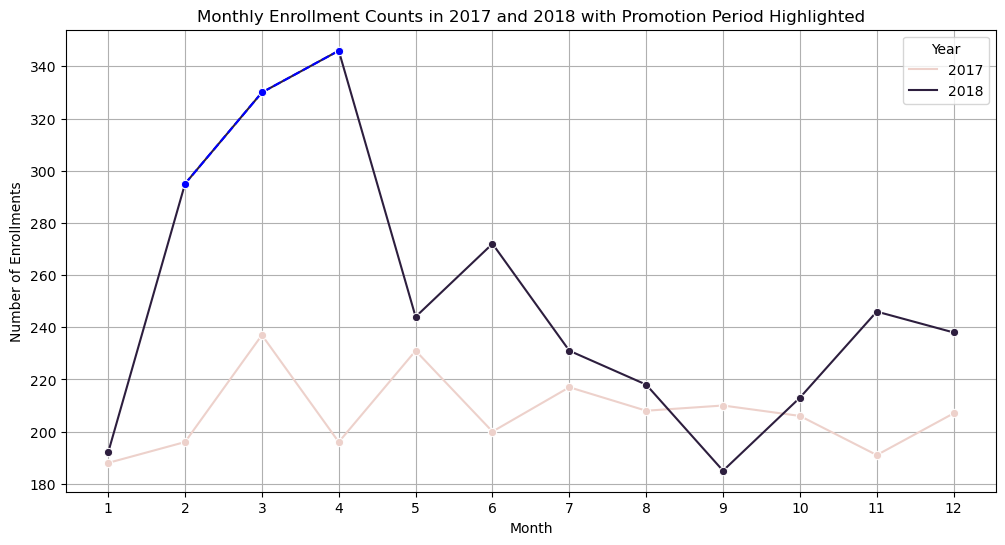

In [23]:
# Setting a colorblind-friendly palette for plotting
sns.set_palette("colorblind")

# Plotting enrollments for 2017 and 2018 with the promotion period highlighted
plt.figure(figsize=(12, 6))
sns.lineplot(data=enrollment_counts, x='Enrollment Month', y='Count', hue='Enrollment Year', marker='o')

# Adding a line for the promotion period
promotion_period_data = enrollment_counts[enrollment_counts['Promotion Period'] == 'Feb-Apr 2018']
sns.lineplot(data=promotion_period_data, x='Enrollment Month', y='Count', color='blue', marker='o', linestyle='--')

plt.title('Monthly Enrollment Counts in 2017 and 2018 with Promotion Period Highlighted')
plt.xlabel('Month')
plt.ylabel('Number of Enrollments')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid(True)
plt.show()

In [24]:
all_years_data.groupby(['Enrollment Year', 'Enrollment Month']).size().reset_index(name='Count')

NameError: name 'all_years_data' is not defined

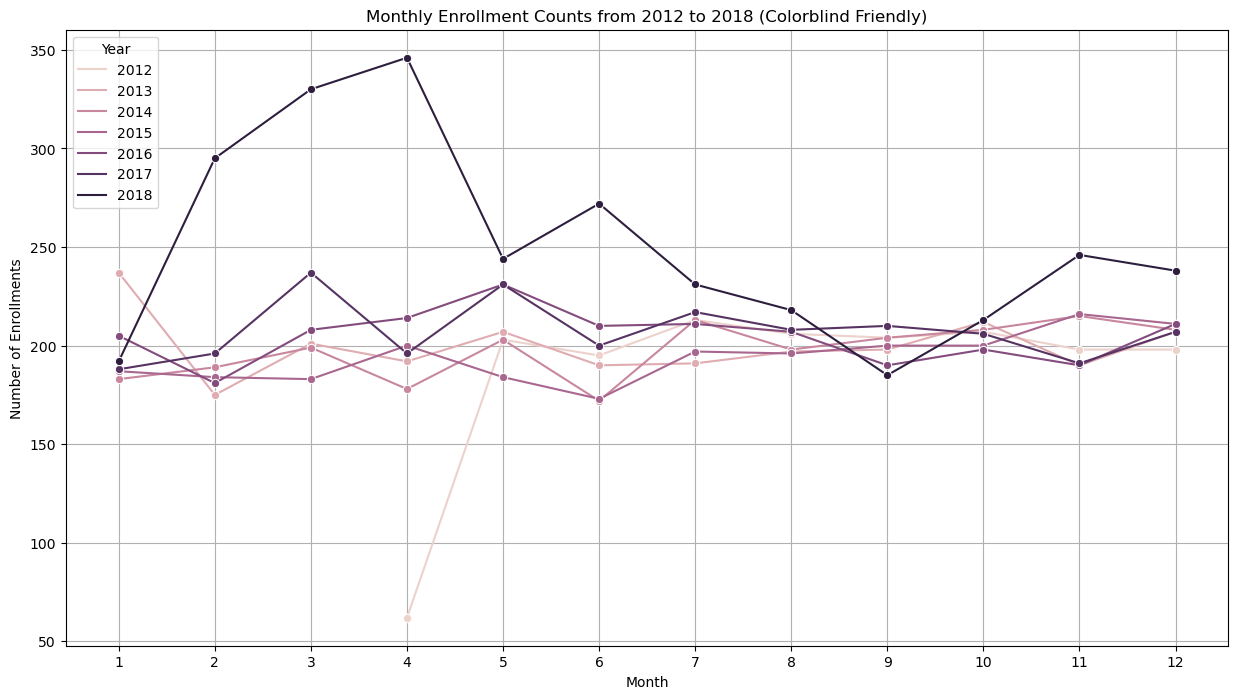

In [25]:
# Filtering data for the years 2012 to 2018
all_years_data = data_member[(data_member['Enrollment Year'] >= 2012) & 
                             (data_member['Enrollment Year'] <= 2018)]

# Counting enrollments per month for each year
all_years_enrollment_counts = all_years_data.groupby(['Enrollment Year', 'Enrollment Month']).size().reset_index(name='Count')

# Plotting enrollments from 2012 to 2018
plt.figure(figsize=(15, 8))
sns.lineplot(data=all_years_enrollment_counts, x='Enrollment Month', y='Count', hue='Enrollment Year', marker='o')

plt.title('Monthly Enrollment Counts from 2012 to 2018 (Colorblind Friendly)')
plt.xlabel('Month')
plt.ylabel('Number of Enrollments')
plt.xticks(range(1, 13))
plt.legend(title='Year', loc='upper left')
plt.grid(True)
plt.show()

Parte 2

Was the campaign adoption more successful for certain demographics of loyalty members?

A adoção da campanha foi mais bem-sucedida para quais grupos demográficos de membros fidelizados?

In [26]:
# Segmenting data for members who joined during the 2018 promotional campaign
campaign_members = data_member[data_member['Enrollment Type'].str.contains('2018', na=False)]
campaign_members

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date
18,172755,Canada,Alberta,Edmonton,T3G 6Y6,Female,College,NaN,Single,Aurora,5303.76,2018 Promotion,2018,3,NaN,NaN,2018-03-01,NaT
36,938981,Canada,Alberta,Edmonton,T3G 6Y6,Female,College,NaN,Single,Aurora,5337.35,2018 Promotion,2018,4,NaN,NaN,2018-04-01,NaT
65,386082,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,30486.0,Divorced,Aurora,5391.97,2018 Promotion,2018,3,2018.0,11.0,2018-03-01,NaT
69,112522,Canada,Alberta,Peace River,T9O 2W2,Male,Bachelor,49846.0,Married,Aurora,5636.74,2018 Promotion,2018,2,NaN,NaN,2018-02-01,NaT
73,330694,Canada,Alberta,Edmonton,T3G 6Y6,Female,Bachelor,105053.0,Married,Aurora,6172.91,2018 Promotion,2018,2,NaN,NaN,2018-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16673,368435,Canada,Yukon,Whitehorse,Y2K 6R0,Female,Bachelor,73695.0,Married,Nova,8707.62,2018 Promotion,2018,4,2018.0,12.0,2018-04-01,NaT
16676,828109,Canada,Yukon,Whitehorse,Y2K 6R0,Female,Bachelor,74049.0,Divorced,Nova,13009.24,2018 Promotion,2018,3,2018.0,11.0,2018-03-01,NaT
16698,909547,Canada,Yukon,Whitehorse,Y2K 6R0,Female,Bachelor,54567.0,Married,Star,5759.01,2018 Promotion,2018,4,NaN,NaN,2018-04-01,NaT
16706,409984,Canada,Yukon,Whitehorse,Y2K 6R0,Male,College,NaN,Single,Star,7452.23,2018 Promotion,2018,4,2018.0,12.0,2018-04-01,NaT


In [27]:
# Analyzing demographics
demographics = ['Province', 'City', 'Gender', 'Education', 'Salary', 'Marital Status']
demographic_analysis = {demo: campaign_members[demo].value_counts().reset_index() 
                        for demo in demographics}
demographic_analysis

{'Province':                    index  Province
 0                Ontario       297
 1       British Columbia       280
 2                 Quebec       233
 3                Alberta        39
 4          New Brunswick        33
 5           Saskatchewan        24
 6               Manitoba        20
 7            Nova Scotia        19
 8           Newfoundland        16
 9                  Yukon         9
 10  Prince Edward Island         1,
 'City':              index  City
 0          Toronto   173
 1        Vancouver   151
 2         Montreal   138
 3      Quebec City    42
 4           Ottawa    32
 5         Victoria    32
 6          Trenton    29
 7         Whistler    29
 8        Tremblant    28
 9     Dawson Creek    28
 10  West Vancouver    25
 11            Hull    25
 12          Regina    24
 13        Edmonton    23
 14     Fredericton    22
 15        Kingston    21
 16        Winnipeg    20
 17         Halifax    19
 18         Sudbury    18
 19      St. John's    16
 

In [28]:
enrollment_provinces = campaign_members.groupby(['Province']).size().reset_index(name='Count').sort_values('Count', ascending = False)
enrollment_provinces

,Province,Count
6,Ontario,297
1,British Columbia,280
8,Quebec,233
0,Alberta,39
3,New Brunswick,33
9,Saskatchewan,24
2,Manitoba,20
5,Nova Scotia,19
4,Newfoundland,16
10,Yukon,9


In [29]:
enrollment_cities = campaign_members.groupby(['City']).size().reset_index(name='Count').sort_values('Count', ascending = False)
enrollment_cities

,City,Count
20,Toronto,173
23,Vancouver,151
12,Montreal,138
15,Quebec City,42
13,Ottawa,32
24,Victoria,32
22,Trenton,29
26,Whistler,29
21,Tremblant,28
3,Dawson Creek,28


In [30]:
enrollment_gender = campaign_members.groupby(['Gender']).size().reset_index(name='Count').sort_values('Count', ascending = False)
enrollment_gender

,Gender,Count
0,Female,494
1,Male,477


In [31]:
enrollment_Education = campaign_members.groupby(['Education']).size().reset_index(name='Count').sort_values('Count', ascending = False)
enrollment_Education

,Education,Count
0,Bachelor,632
1,College,238
3,High School or Below,50
2,Doctor,32
4,Master,19


In [32]:
enrollment_Salary = campaign_members.groupby(['Salary']).size().reset_index(name='Count').sort_values('Count', ascending = False)
enrollment_Salary

,Salary,Count
347,64373.0,3
47,24287.0,2
606,92396.0,2
460,74651.0,2
463,74964.0,2
...,...,...
239,55120.0,1
240,55130.0,1
241,55271.0,1
242,55317.0,1


In [33]:
enrollment_Marital_Status = campaign_members.groupby(['Marital Status']).size().reset_index(name='Count').sort_values('Count', ascending = False)
enrollment_Marital_Status

,Marital Status,Count
1,Married,558
2,Single,258
0,Divorced,155


In [ ]:
# Plotting demographics with shades of blue
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Plot for Province
sns.barplot(x='Count', y='Province', data=enrollment_provinces, ax=axes[0, 0], palette="Blues_r")
axes[0, 0].set_title('Enrollments by Province')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Province')

# Plot for City (top 10 cities)
top_cities = enrollment_cities.head(10)
sns.barplot(x='Count', y='City', data=top_cities, ax=axes[0, 1], palette="Blues_r")
axes[0, 1].set_title('Enrollments by City (Top 10)')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('City')

# Plot for Gender with labels
gender_plot = sns.barplot(x='Gender', y='Count', data=enrollment_gender, ax=axes[1, 0], palette="Blues_r")
axes[1, 0].set_title('Enrollments by Gender')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Count')
for p in gender_plot.patches:
    gender_plot.annotate(f"{int(p.get_height())}", 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         fontsize=12, 
                         color='black', 
                         xytext=(0, 5), 
                         textcoords='offset points')

# Plot for Education
sns.barplot(x='Count', y='Education', data=enrollment_Education, ax=axes[1, 1], palette="Blues_r")
axes[1, 1].set_title('Enrollments by Education')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Education')

# Plot for Marital Status
sns.barplot(x='Marital Status', y='Count', data=enrollment_Marital_Status, ax=axes[2, 0], palette="Blues_r")
axes[2, 0].set_title('Enrollments by Marital Status')
axes[2, 0].set_xlabel('Marital Status')
axes[2, 0].set_ylabel('Count')

# Removing the empty plot
axes[2, 1].axis('off')

plt.show()

Parte 3

What impact did the campaign have on booked flights during summer 2018?

Que impacto teve a campanha nos voos reservados durante o verão de 2018?

In [34]:
data_member.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN,2016-02-01,NaT
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN,2016-03-01,NaT
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0,2014-07-01,NaT
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN,2013-02-01,NaT
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN,2014-10-01,NaT


In [35]:
# Filter the flight activity data for summer months (June, July, August) for the years 2017 and 2018
summer_months = [6, 7, 8]
summer_activity_data = data_flight[
    (data_flight['Year'].isin([2017, 2018])) &
    (data_flight['Month'].isin(summer_months))
]
summer_activity_data

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
102,471706,2018,7,12,10,22,5896,589.0,445,36
124,100504,2017,6,0,0,0,0,0.0,0,0
125,100504,2017,7,0,0,0,0,0.0,0,0
150,100504,2017,8,10,4,14,966,96.0,0,0
199,100504,2018,6,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
405476,421923,2017,8,11,4,15,960,96.0,768,62
405488,356460,2017,6,12,4,16,1024,102.0,823,66
405584,999891,2018,6,0,0,0,0,0.0,0,0
405591,999891,2018,7,0,0,0,0,0.0,0,0


In [36]:
# Grouping data by year and month for summer months
monthly_flights_by_year = summer_activity_data.groupby(['Year', 'Month'])['Flights Booked'].sum().reset_index()
monthly_flights_by_year

,Year,Month,Flights Booked
0,2017,6,80493
1,2017,7,89288
2,2017,8,78692
3,2018,6,92749
4,2018,7,104143
5,2018,8,90512


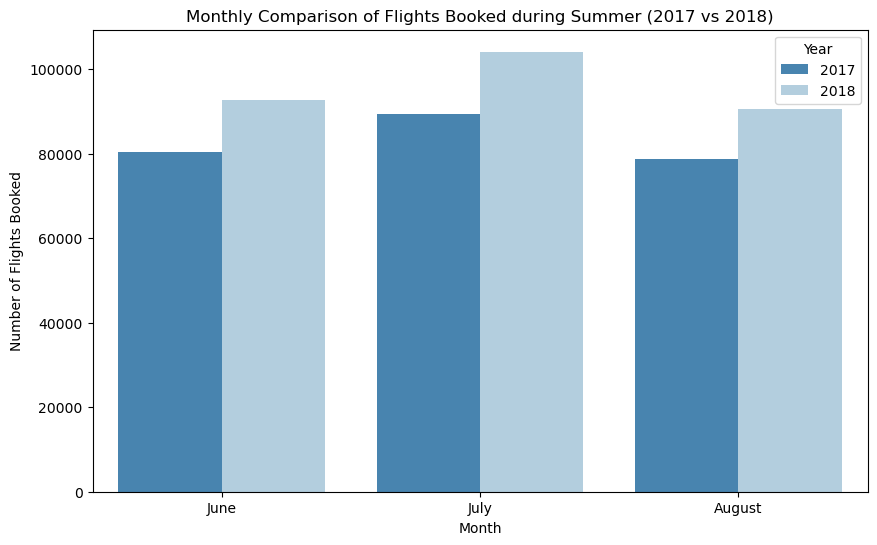

In [37]:
# Plotting the comparison of summer flights booked in 2017 vs 2018, month by month
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Flights Booked', hue='Year', data=monthly_flights_by_year,palette="Blues_r")
plt.title('Monthly Comparison of Flights Booked during Summer (2017 vs 2018)')
plt.xlabel('Month')
plt.ylabel('Number of Flights Booked')
plt.xticks(ticks=[0, 1, 2], labels=['June', 'July', 'August'])
plt.legend(title='Year')
plt.show()

Parte 4

Can I build a machine learning model to predict Churn risk?

Posso criar um modelo de aprendizado de máquina para prever o risco de Churn?


In [38]:
data_member.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN,2016-02-01,NaT
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN,2016-03-01,NaT
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0,2014-07-01,NaT
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN,2013-02-01,NaT
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN,2014-10-01,NaT


In [39]:
data_flight.head()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


In [40]:
# Combine Cancellation Year and Month into customer status
def Customer_Status(row):
    if pd.isna(row['Cancellation Year']) or pd.isna(row['Cancellation Month']):
        return 'Stayed'
    else:
        return 'Churned'

In [41]:
data_member['Customer_Status'] = data_member.apply(Customer_Status, axis=1)

In [42]:
data_member.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,Customer_Status
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN,2016-02-01,NaT,Stayed
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN,2016-03-01,NaT,Stayed
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0,2014-07-01,NaT,Churned
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN,2013-02-01,NaT,Stayed
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN,2014-10-01,NaT,Stayed


In [43]:
## Aggregating flight activity data
flight_activity_summary = data_flight.groupby('Loyalty Number').agg({
    'Flights Booked': 'sum',
    'Distance': 'sum',
    'Points Accumulated': 'sum',
    'Points Redeemed': 'sum'
}).reset_index()

flight_activity_summary

,Loyalty Number,Flights Booked,Distance,Points Accumulated,Points Redeemed
0,100018,157,50682,5376.00,1513
1,100102,173,40222,4115.25,1195
2,100140,152,41252,4184.25,593
3,100214,79,33982,3426.00,861
4,100272,127,40872,4108.04,1007
...,...,...,...,...,...
16732,999902,178,57227,6056.50,876
16733,999911,0,0,0.00,0
16734,999940,63,23410,2415.00,672
16735,999982,22,5948,594.00,0


In [44]:
merged_data = pd.merge(data_member, flight_activity_summary, how='left', on='Loyalty Number')
merged_data.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,...,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,Customer_Status,Flights Booked,Distance,Points Accumulated,Points Redeemed
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,...,2,NaN,NaN,2016-02-01,NaT,Stayed,132,51877,5224.44,1418
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,...,3,NaN,NaN,2016-03-01,NaT,Stayed,190,41578,4176.04,1971
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,...,7,2018.0,1.0,2014-07-01,NaT,Churned,66,19664,1963.00,374
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,...,2,NaN,NaN,2013-02-01,NaT,Stayed,123,36043,3626.68,1291
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,...,10,NaN,NaN,2014-10-01,NaT,Stayed,132,36840,3689.68,0


In [45]:
# Creating the target variable: 1 for Churned, 0 for Stayed
merged_data['Customer_Status'] = merged_data['Customer_Status'].map({'Churned': 1, 'Stayed': 0})

In [46]:
merged_data

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,...,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,Customer_Status,Flights Booked,Distance,Points Accumulated,Points Redeemed
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,...,2,NaN,NaN,2016-02-01,NaT,0,132,51877,5224.44,1418
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,...,3,NaN,NaN,2016-03-01,NaT,0,190,41578,4176.04,1971
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,...,7,2018.0,1.0,2014-07-01,NaT,1,66,19664,1963.00,374
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,...,2,NaN,NaN,2013-02-01,NaT,0,123,36043,3626.68,1291
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,...,10,NaN,NaN,2014-10-01,NaT,0,132,36840,3689.68,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16732,823768,Canada,British Columbia,Vancouver,V6E 3Z3,Female,College,NaN,Married,Star,...,12,NaN,NaN,2012-12-01,NaT,0,126,40743,4070.00,0
16733,680886,Canada,Saskatchewan,Regina,S1J 3C5,Female,Bachelor,89210.0,Married,Star,...,9,NaN,NaN,2014-09-01,NaT,0,198,43420,4348.76,1645
16734,776187,Canada,British Columbia,Vancouver,V5R 1W3,Male,College,NaN,Single,Star,...,3,NaN,NaN,2014-03-01,NaT,0,174,49113,4925.56,1529
16735,906428,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,-57297.0,Married,Star,...,4,NaN,NaN,2018-04-01,NaT,0,128,41381,4166.44,0


In [47]:
# Selecting features for the model
features = ['Province', 'City', 'Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card', 'CLV',
            'Flights Booked', 'Distance', 'Points Accumulated', 'Points Redeemed']
X = merged_data[features].copy()  # Create a copy to avoid SettingWithCopyWarning
y = merged_data['Customer_Status']


In [48]:
# Checking the distribution of the target variable
print(y.value_counts())

0    14670
1     2067
Name: Customer_Status, dtype: int64


In [49]:
# Encoding categorical variables
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column].astype(str))



In [50]:
# Handling missing values
X.fillna(0, inplace=True)

In [51]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

In [53]:
# Predicting on the test set
y_pred = model.predict(X_test)

In [54]:
# Evaluating the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4422
           1       0.88      0.01      0.02       600

    accuracy                           0.88      5022
   macro avg       0.88      0.51      0.48      5022
weighted avg       0.88      0.88      0.83      5022



In [55]:
# Feature importance
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))

               Feature  Importance
10  Points Accumulated    0.371011
9             Distance    0.301589
8       Flights Booked    0.207102
11     Points Redeemed    0.062551
7                  CLV    0.035164
1                 City    0.009526
4               Salary    0.006244
0             Province    0.003618
6         Loyalty Card    0.002977
5       Marital Status    0.000119
3            Education    0.000100
2               Gender    0.000000


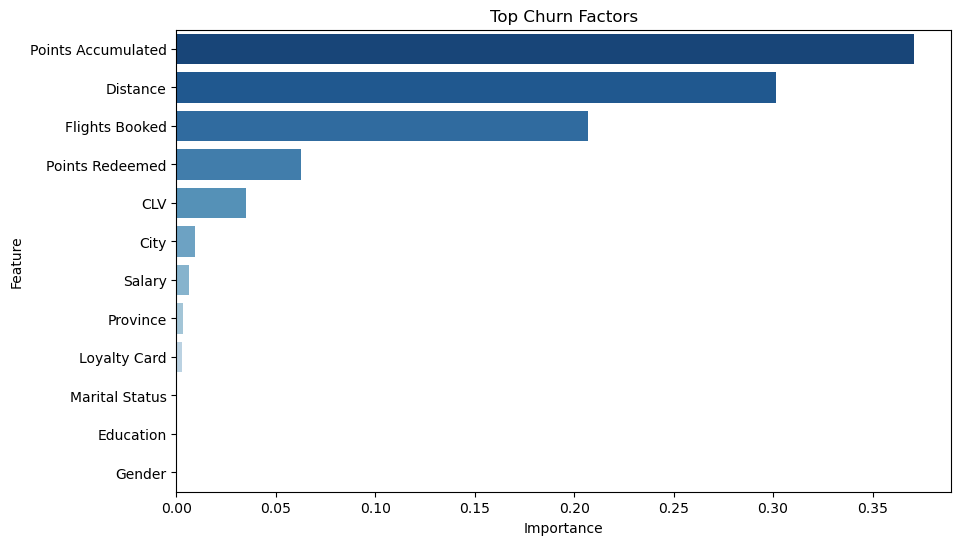

In [56]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance (high to low)
feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_sorted, palette='Blues_r')
plt.title('Top Churn Factors')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()